# EXERCISE 6.4: Field boundary delineation 

---

**Use of RadiantMLHub with Rwanda geodata and keras to train a CNN to predict the boundaries of fields**

*This notebook is adapted from Nasa Harvest Rwanda Field Boundary Detection Challenge Tutorial*

Why agricultural field delineation is important?


1.  Crop management: Knowing the exact boundaries of a field allows farmers to manage their crops more effectively. They can apply fertilizers, pesticides, and herbicides only where they are needed, reducing waste and the potential for negative environmental impacts. Delineation also allows for more precise irrigation and planting, which can improve crop yields.
2.   Resource allocation: With accurate field boundaries, farmers can more accurately allocate resources such as labor, equipment, and inputs to each field. This can help increase efficiency and reduce costs.
3. Planning and decision-making: Accurate field delineation is important for crop planning and decision-making. It can help farmers determine which crops are best suited for each field based on soil types, slope, and other factors. It can also help them make decisions about crop rotation and fallow periods.
4. Compliance: In some areas, farmers may be required by law to accurately delineate their fields for environmental or regulatory purposes. For example, in the United States, farmers who participate in certain government programs are required to maintain accurate field boundaries.



Small farms (<2ha) produce about 35% of the world’s food, and are mostly found in low- and middle-income countries. Mapping these farms allows policy-makers to allocate resources and monitor the impacts of extreme events on food production and food security. Unfortunately, these field-level maps remain mostly unavailable in low and middle income countries, where the food insecurity risk is highest. Combining machine learning with Earth Observation data from satellites like the PlanetScope constellation can help improve agricultural monitoring, cropland mapping, and disaster risk management for these small farms.

In this challenge, the goal is to classify crop field boundaries using multispectral observations collected by PlanetScope, available through the NICFI basemaps program. Fields are located in Rwanda’s Eastern Province (Intara y’lburasirazuba) and spread over the districts of Gatsibo and Nyagatare. The NASA Harvest Rwanda field boundary training dataset was generated by TaQadam through a team of annotators, and curated by Radiant Earth Foundation.


# Dataset
The dataset is hosted at [Radiant MLHub](https://mlhub.earth/data/nasa_rwanda_field_boundary_competition) and contains field boundaries for smallholder farms in eastern Rwanda. The Nasa Harvest program funded a team of annotators from TaQadam to label Planet imagery for the 2021 growing season for the purpose of conducting the Rwanda Field boundary detection Challenge. The dataset includes rasterized labeled field boundaries and time series satellite imagery from Planet's NICFI program. Planet's basemap imagery is provided for six months (March, April, August, October, November and December). The paired dataset is provided in 256x256 chips for a total of 70 tiles covering 1532 individual fields.

#Access the dataset

To access the dataset from Radiant MLHub, you need to create an account on Radiant MLHub, you can follow these steps:

1. Go to the Radiant MLHub website at https://www.mlhub.earth/.
2. Click on the "Sign In" button in the top right corner of the homepage.
3. Click on the "Create Account" button.
4. Enter your email address and create a password for your account.
5. Click on the "Create Account" button.
6. You will receive an email to verify your account. Click on the verification link in the email.
7. Once your account is verified, you can log in to Radiant MLHub using your email address and password.


After logging in, you can access the various datasets and resources available on Radiant MLHub. To access the dataset of interest in this colab, we need an MLHUB_API_KEY, which is obtained by following these steps:

1. Log in (if not already) to your Radiant MLHub account on https://www.mlhub.earth/.
2. Click on your profile icon in the top right corner of the homepage.
3. Select "API Keys" from the drop-down menu.
3. You will see a list of your API keys, if you have any created before. Otherwise, click on the "Create a new API Key" button.
4. Give your new API key a name and select the permissions you want to grant it.
5. Click on the "Create" button.
Your new API key will be displayed on the screen. Copy and save the key somewhere safe.

You can use your MLHUB_API_KEY to authenticate your requests to the Radiant MLHub API, which will allow you to access and download datasets and use other resources available on the platform. Be sure to keep your API key secure and not share it with others, as it provides access to your Radiant MLHub account and data.

This notebook walks you through the steps to create a baseline field delineation model for detecting boundaries from sentinel-2 time-series satellite imagery using a spatio-temporal U-Net model on the 2021 NASA Harvest dataset. The goal is to classify crop field boundaries using multispectral observations collected by PlanetScope, available through the NICFI basemaps program. Fields are located in Rwanda’s Eastern Province and spread over the districts of Gatsibo and Nyagatare. The NASA Harvest Rwanda field boundary training dataset was generated by TaQadam through a team of annotators, and curated by Radiant Earth Foundation.

In [ ]:
#connect/mount to drive where our requirement resources are located
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dependencies

All the dependencies for this notebook to run on colab are included in the `requirements_colab.txt` file included in this folder. To run the model on GPU you should go to edit/notebook settings and select GPU

In [ ]:
#Change directory accordingly
!pip install -r '/content/drive/MyDrive/ML4EO/6_04_Field_boundary_delineation/requirements_colab.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 

In [ ]:
#Libraries in case the above are note compatible
#!pip install keras==2.6.1
#!pip install tensorflow==2.8.0


In [ ]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
import shutil
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm

from pathlib import Path
from radiant_mlhub import Dataset
from random import choice
from segmentation_models import Unet
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple

Segmentation Models: using `keras` framework.


Data

In [ ]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [ ]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

MLHub API Key: ··········


In [ ]:
dataset.download(output_dir = dataset_id, if_exists='overwrite')

  0%|          | 0/0.4 [00:00<?, ?M/s]

  0%|          | 0/112.5 [00:00<?, ?M/s]

  0%|          | 0/25.5 [00:00<?, ?M/s]

[PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_labels_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_test.tar.gz')]

In [ ]:
archives = ['source_train', 'source_test', 'labels_train']

In [ ]:
for archive in archives:
  full_path = f"{dataset_id}/{dataset_id}_{archive}.tar.gz"
  shutil.unpack_archive(full_path, dataset_id)

In [ ]:
#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [ ]:
train_source_items = f"{dataset_id}/{dataset_id}_source_train"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

In [ ]:
next(os.walk(train_source_items))[1][0]

'nasa_rwanda_field_boundary_competition_source_train_36_2021_12'

In [ ]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [ ]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

## Question 6.4.1
Complete thfunction completing the function below

In [ ]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max() #Answer
    return (array - array_min) / (array_max - array_min) #Answer

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

Image augmentation is a powerful technique for improving the performance of machine learning models, especially when working with limited amounts of data. In the context of agricultural field delineation, image augmentation can help improve the accuracy of the model by increasing the variability and diversity of the input data.


We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector).
We will observe the results on a random source image and its associated label below:

In [ ]:
#loading the 4 bands of the image
tile = random.choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

45_2021_10


In [ ]:
#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

In [ ]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

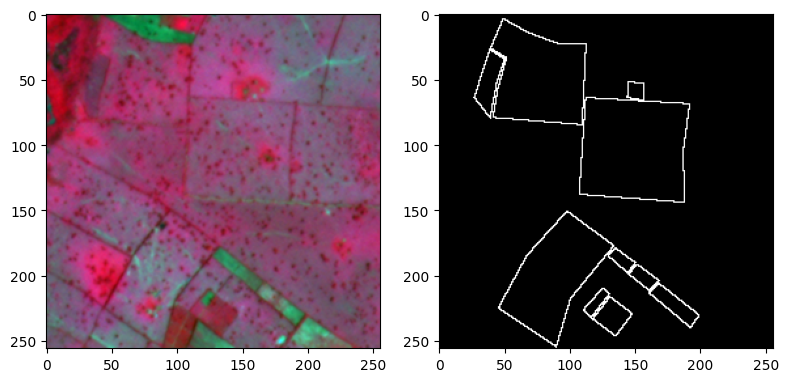

In [ ]:
show_image(field, mask)

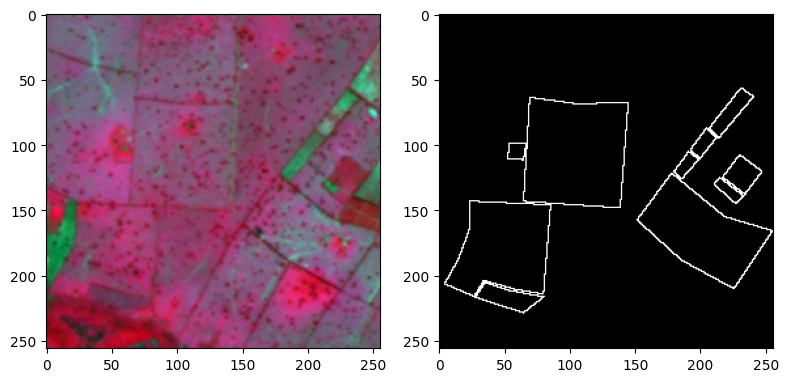

In [ ]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

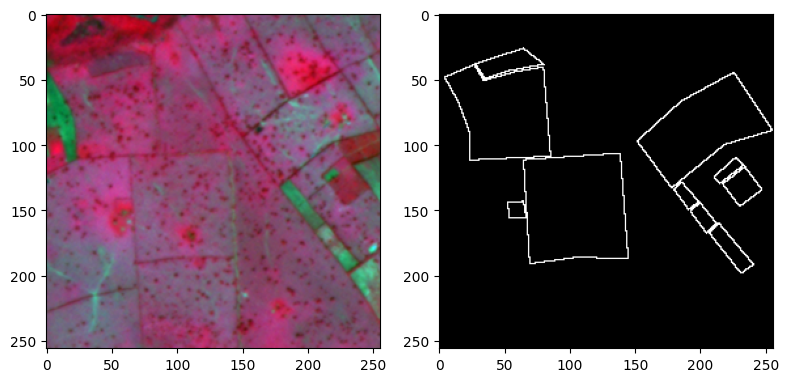

In [ ]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

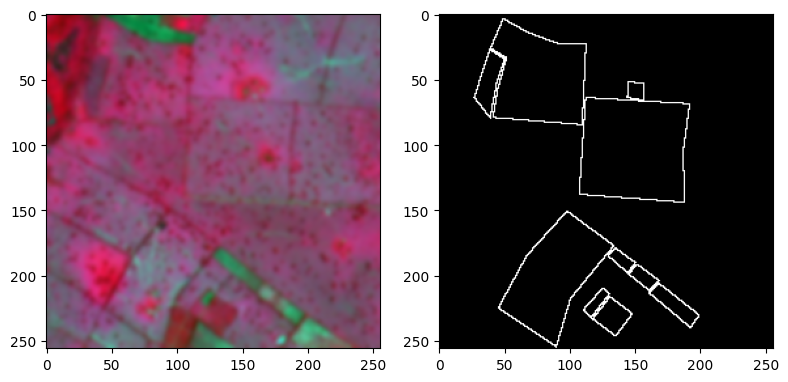

In [ ]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [ ]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3], [0,1,2,3] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [ ]:
#apply augmentation effects to training set
for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"./augmented_data/{timestamp}"):
        os.makedirs(f"./augmented_data/{timestamp}")
    if not os.path.isdir(f"./augmented_data/{timestamp}/fields"):
        os.makedirs(f"./augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"./augmented_data/{timestamp}/masks"):
        os.makedirs(f"./augmented_data/{timestamp}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = tile_id,
        write_folder = f"./augmented_data/{timestamp}"
    ) #approximately 30 seconds

In [ ]:
timestamps = next(os.walk(f"./augmented_data"))[1] #Get all timestamps
augmented_files = next(os.walk(f"./augmented_data/{timestamps[0]}/fields"))[2] #Get all augmented tile ids. can just use one timestamp
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for timestamp in timestamps:
        with open(f"./augmented_data/{timestamp}/fields/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"./augmented_data/{timestamp}/masks/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1

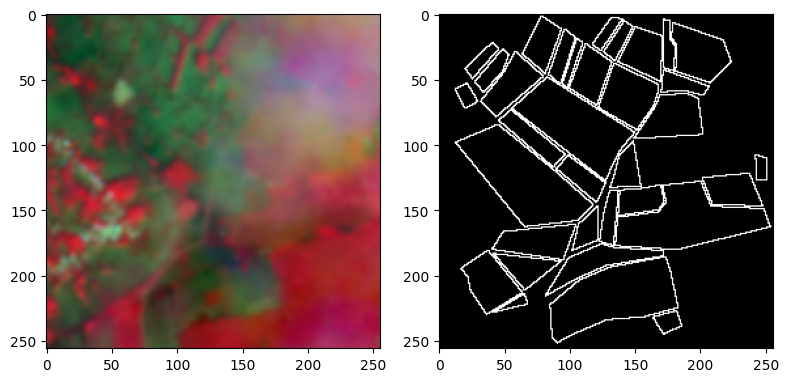

In [ ]:
random_image = random.randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:3], y[random_image].reshape(IMG_WIDTH, IMG_HEIGHT))

## Question 6.4.2
Why do we only use data augmentation on training data?


Data augmentation is typically only used on the training data because the goal is to improve the model's ability to generalize to new, unseen data. By augmenting the training data, the model is exposed to a wider variety of examples and variations, which can help it learn to recognize the underlying patterns and features of the data more robustly.

### Model Training

The notebook uses U-Net as it has shown impressive results over multiple domains in image segmentation. The model uses a ResNet34 as a backbone and is a widely-used convolutional neural network architecture that has been shown to perform well on image classification tasks.

The term "backbone" refers to the architecture of the convolutional neural network (CNN) used as the feature extractor in a larger model.

The model uses 24 channels (6 timestamps * 4 bands per timestamp) and generates the predicted field boundary per scene. The 24 channels means each input feature map is a 2D array of values that represents the reflectance per wavelength region measured at the pixel level. In this case, the model uses four spectral bands (red, green, blue, and near-infrared) and six time steps, resulting in a total of 24 feature maps.


The model also uses a 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary),`binary cross_entropy` loss is used.

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
X = preprocess_input(X)

In [ ]:
#https://github.com/sustainlab-group/ParcelDelineation/blob/master/models/unet.py
def unet(pretrained_weights = None,input_size = (256,256,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return 

The model expects the definition of the learning rate as a hyperparameter. The learning rate controls the step size taken by the optimizer during training to update the model parameters. It determines the magnitude of the changes made to the weights and biases of the model at each iteration of the training process.

The choice of learning rate can have a significant impact on the training process and the performance of the model. A learning rate that is too high can cause the optimization process to overshoot the optimal weights and biases, leading to instability and poor performance. On the other hand, a learning rate that is too low can cause the optimization process to converge very slowly, resulting in longer training times and potentially suboptimal performance.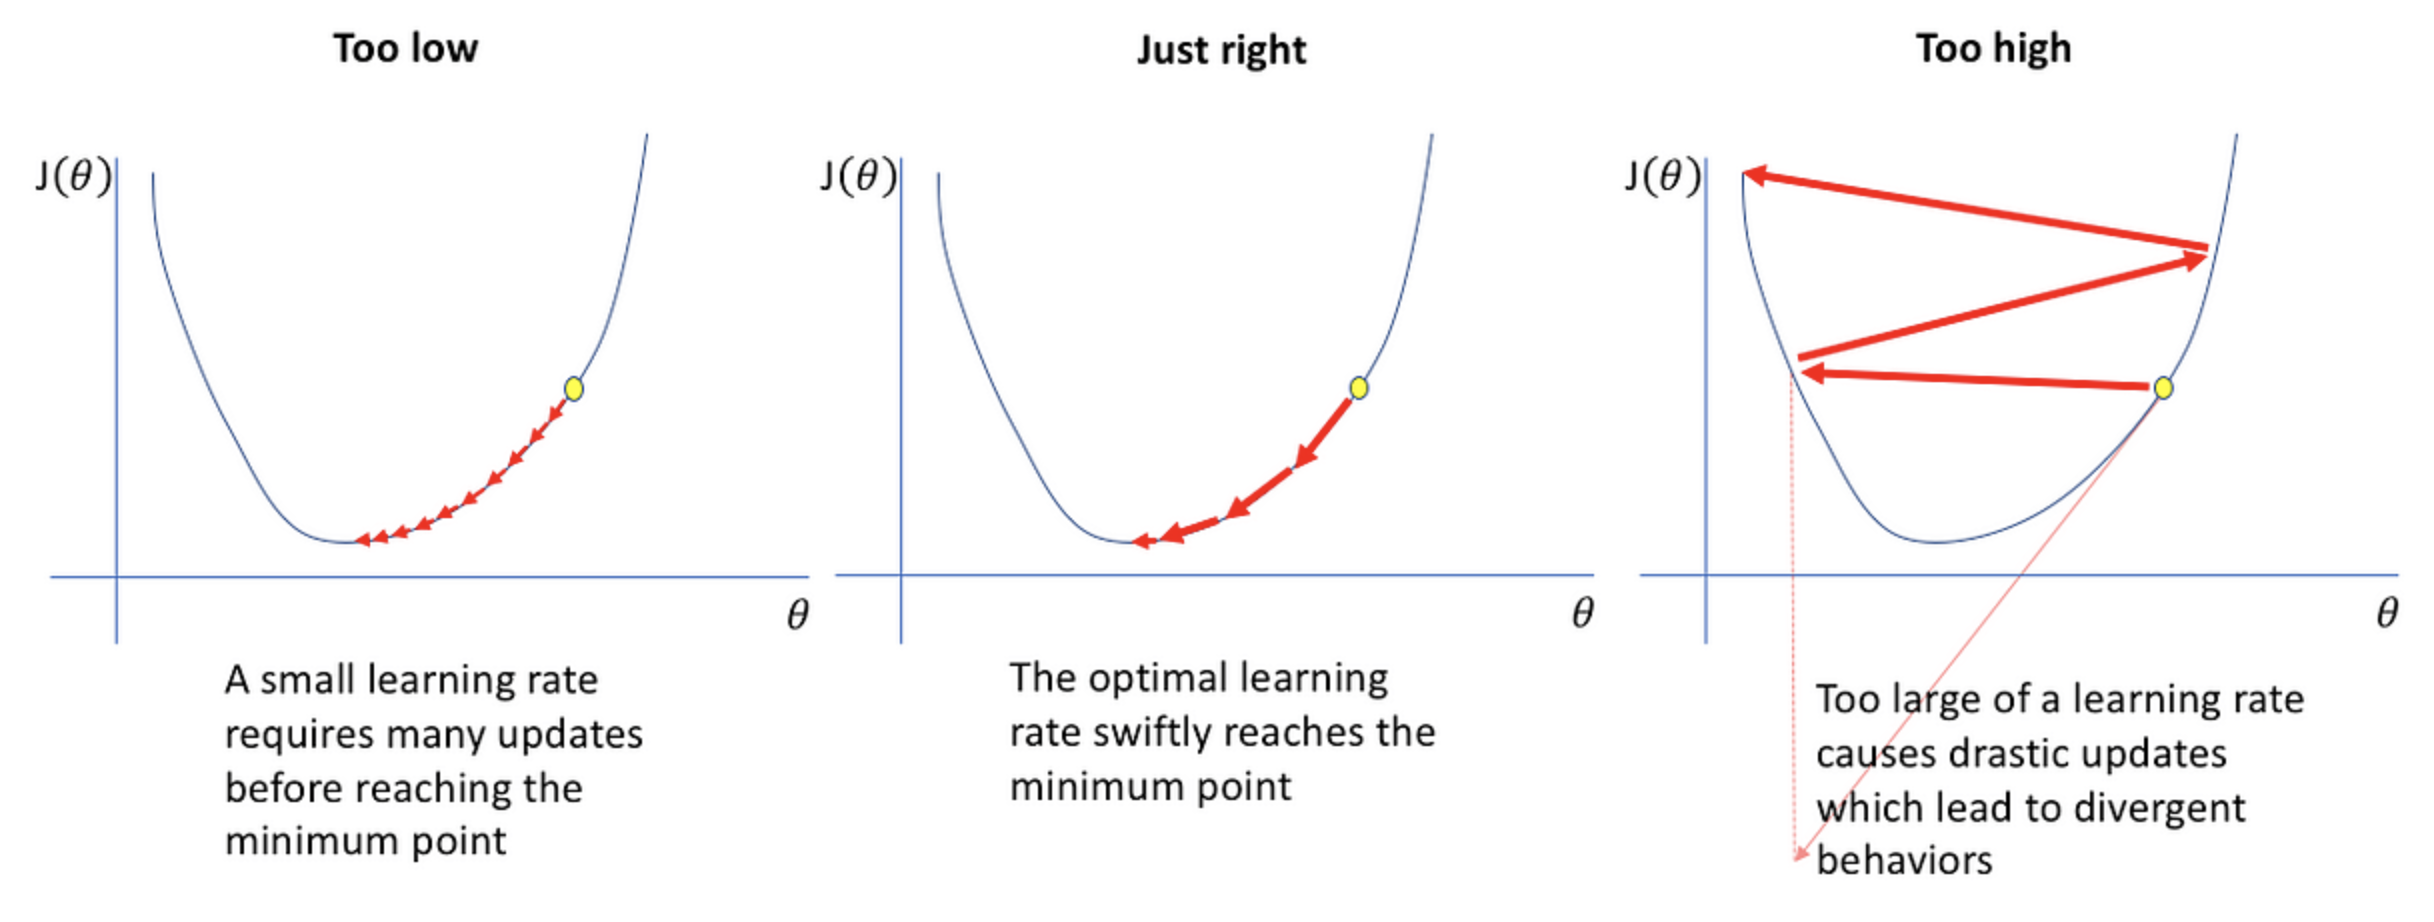

In the agricultural field delineation model, the choice of learning rate would depend on the specific dataset and training setup. Typically, the learning rate is set through a process of hyperparameter tuning, where different learning rates are tried and the performance of the model is evaluated on a validation set. Common techniques for setting the learning rate include using a fixed learning rate, using a learning rate schedule that gradually decreases the learning rate over time, or using adaptive learning rate algorithms such as Adam or Adagrad.

In [ ]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

In the agricultural field delimitation model, the input shape is set to (256, 256, num_channels), where num_channels is 24, as discussed earlier. This means that each input image has a resolution of 256 x 256 pixels, and there are 24 input feature maps representing the different time steps and spectral bands.

The batch size is set to 4, which means that during each iteration of the training process, the optimizer will update the model weights based on the gradient computed using 4 input images. The choice of batch size can have an impact on the training process, as a larger batch size can lead to faster convergence but may also require more memory and computation. A smaller batch size, on the other hand, may be slower to converge but can enable better generalization and avoid overfitting.

The specific choice of input shape and batch size will depend on the characteristics of the dataset, the available hardware resources, and the desired trade-off between training time and model performance. In general, larger input shapes and batch sizes can lead to more accurate models but may also require more powerful hardware to train efficiently.

In [ ]:
num_channels = 24
input_shape = (256,256,num_channels)
batch_size = 4

The error metric is mainly the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer score to 1, the better your model.

F1 Score: A performance score that combines both precision and recall. It is a harmonic mean of these two variables. Formula is given as: 2*Precision*Recall/(Precision + Recall)


Recall / Sensitivity / True Positive Rate (TPR): This is an indicator of the number of items correctly identified as positive out of total actual positives. Formula is given as: TP/(TP+FN)

Where:

TP=True Positive
FP=False Positive
TN=True Negative
FN=False Negative


In [ ]:
#Two function for evaluating the model, recall and F1-Score

def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

The code below defines the architecture and compiles the model for the agricultural field delimitation task. The model architecture consists of a ResNet34 backbone with a U-Net architecture for image segmentation. The ResNet34 backbone is initialized with pre-trained weights from the ImageNet dataset, and the U-Net architecture is added on top to enable precise segmentation of the agricultural fields.

The 1x1 Conv2D operation that is added before the UNet to serve as a feature map multiplier. It helps to reduce the number of channels in the input feature maps, which can be especially helpful when dealing with large images or deep neural network architectures. Another benefit of using a 1x1 Conv2D operation is that it helps to preserve spatial information in the input feature maps. Since the operation involves a single convolutional filter with a small kernel size, it does not alter the spatial dimensions of the input feature maps, allowing the UNet to still make use of all of the spatial information in the input.

In [ ]:
sm.set_framework('tf.keras')
sm.framework()
model = None 
model_unet = Unet(BACKBONE, encoder_weights='imagenet')
new_model = keras.models.Sequential()
new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
new_model.add(model_unet)
model = new_model 
#sm.metrics.FScore(beta=1)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler(0)),
              metrics=[recall,f1])

85532672/85521592 [==============================] - 1s 0us/step
Set Learning Rate : 0.0001


The model summary function is used to print a summary of the model architecture, including the number of parameters in each layer, the output shape of each layer, and the total number of trainable and non-trainable parameters in the model.

Printing the model summary can be helpful for debugging and understanding the structure of the model. It can also be used to check if the model is constructed as intended and to compare the number of parameters in different models.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       75        
                                                                 
 model_1 (Functional)        (None, None, None, 1)     24456154  
                                                                 
Total params: 24,456,229
Trainable params: 24,438,879
Non-trainable params: 17,350
_________________________________________________________________


Here, training and test data are splited on a ratio of 80:20

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Here, eager, a command in TensorFlow that sets eager execution mode to true.Eager execution is a mode of TensorFlow that evaluates operations immediately as they are called instead of building a computational graph to execute later. In other words, with eager execution, TensorFlow performs the computations directly and immediately, which can be helpful for debugging and testing.

When running TensorFlow in eager execution mode, computations are performed in a more intuitive way, making it easier to reason about the code and to debug. It also allows for more dynamic and flexible control of the model's execution, which can be helpful when experimenting with new architectures or training strategies.

However, eager execution mode can also be slower than graph-based execution, especially when dealing with large datasets or complex models. Therefore, it is usually recommended to turn off eager execution mode for production-level models or large-scale training.



In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


The code below trains the compiled model using the fit() function in TensorFlow. The fit() function trains the model for a given number of epochs (in this case, 50 epochs) on the training dataset and evaluates the performance of the model on the validation dataset after each epoch.


The batch_size parameter specifies the number of samples to use in each training batch, which affects the number of updates performed per epoch. The epochs parameter specifies the number of epochs to train the model for.

During training, the model updates its parameters using the backpropagation algorithm and the optimizer specified during model compilation. The loss function specified during model compilation is used to calculate the loss for each training batch, and the model is evaluated on the validation dataset after each epoch.


In [ ]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=50)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
45/45 [==============================] - 25s 279ms/step - loss: 0.7859 - recall: 0.6123 - f1: 0.0967 - val_loss: 0.5826 - val_recall: 0.0450 - val_f1: 0.0288
Epoch 2/50
45/45 [==============================] - 12s 226ms/step - loss: 0.5765 - recall: 0.0602 - f1: 0.0532 - val_loss: 0.6424 - val_recall: 0.0337 - val_f1: 0.0336
Epoch 3/50
45/45 [==============================] - 12s 262ms/step - loss: 0.4998 - recall: 0.0153 - f1: 0.0230 - val_loss: 0.5595 - val_recall: 0.0105 - val_f1: 0.0170
Epoch 4/50
45/45 [==============================] - 12s 274ms/step - loss: 0.4461 - recall: 0.0073 - f1: 0.0128 - val_loss: 0.5133 - val_recall: 0.0062 - val_f1: 0.0112
Epoch 5/50
45/45 [==============================] - 12s 276ms/step - loss: 0.4046 - recall: 0.0029 - f1: 0.0055 - val_loss: 0.4667 - val_recall: 0.0026 - val_f1: 0.0051
Epoch 6/50
45/45 [==============================] - 11s 233ms/step - loss: 0.3738 - recall: 0.0016 - f1: 0.0031 - val_loss: 0.4274 - val_recall: 1.5507e-04

Plotting the learning curves for the training and validation loss can provide valuable insights into how well a neural network model is learning from the training data and generalizing to new data.

The training loss represents how well the model is fitting the training data over the course of training. Ideally, the training loss should decrease over time as the model learns to better fit the training data. If the training loss stops decreasing early in training, it may indicate that the model is not complex enough to learn the underlying patterns in the data. Conversely, if the training loss continues to decrease while the validation loss starts to increase, it may indicate that the model is overfitting to the training data and is not generalizing well to new data.

The validation loss represents how well the model is performing on a held-out validation set during training. The validation loss can provide an estimate of how well the model is generalizing to new data. If the validation loss is significantly higher than the training loss, it may indicate that the model is overfitting to the training data and is not generalizing well to new data. If the validation loss starts to increase while the training loss continues to decrease, it may indicate that the model is starting to overfit to the training data.

## Question 6.4.3
Complete the following code to plot training and validation loss. Replace `<FILL-IN>` with respective codes

In [ ]:
# Get training and validation loss from the history object
train_loss = history.history['loss'] #Answer
val_loss = history.history['val_loss'] #Answer

# Plot the learning curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save(f"./unet_model.h5")

In [ ]:
model = load_model(f"./unet_model.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1})

### Loading test chips to run predictions

After training the model, it is used to make predictions on new data using the predict() function in TensorFlow.

In [ ]:
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [ ]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [ ]:
X_test = np.empty((len(test_tile_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in timestamps:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)
        
        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        X_test[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx+=IMG_CHANNELS
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches 
    i+=1

In [ ]:
predictions_dictionary = {}
for i in range(len(test_tile_ids)):
    model_pred = model.predict(np.expand_dims(X_test[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    predictions_dictionary.update([(str(loaded_tiles[i]), pd.DataFrame(model_pred))])

In [ ]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

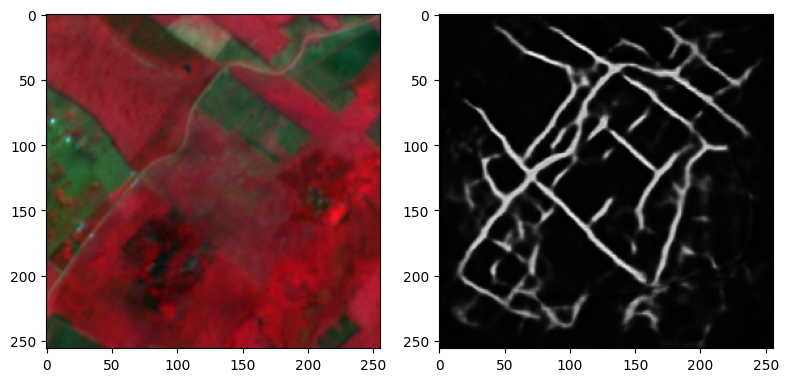

In [ ]:
test_image = random.randint(0, len(X_test)-1)

model_pred = model.predict(np.expand_dims(X_test[test_image], 0))
model_pred = model_pred[0]

show_image(X_test[test_image][:,:,0:3], model_pred[:,:])

The competition has closed, but submission is still possible to get your results evaluated via ZINDI platform.
To submit the result, sign up to [ZINDI](https://zindi.africa/signin) platform and jooin the competition.
 
 
 For submission you need to convert each predicted array into a pandas dataframe and then flatten them using the unstack function. The flattened dataframes will have one record for each combination of row and column (65536 records) and one value for the predicted label. You will concatenate all unstacked dataframes into a single dataframe with 851 968 records and save the output as two column csv (tile_row_column, label) as your submission file.

Your submission file should look like this:


```
Tile_row_column   Label   
Tile1_0_0           0   
Tile1_0_1           1   
Tile1_0_2           0
```




In [ ]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

In [ ]:
sub.to_csv(f"./harvest_sample_submission.csv", index = False)